In [30]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import pprint
from uszipcode import SearchEngine
from config import api_key
from census import Census

In [31]:
# Read in data from csv file
final_df = pd.read_csv("Resources/chicago_crimes_all_cleaned.csv")
final_df

,Case Number,Date,Block,Primary Type,Description,District,Ward,Year,Latitude,Longitude,Location,Population,Zipcode
0,JC104662,12/31/2018 11:59:00 PM,112XX S SACRAMENTO AVE,MINOR PROPERTY CRIME,TO VEHICLE,22,19.0,2018,41.689079,-87.696064,"(41.689078832, -87.696064026)",28804.0,60655.0
1,JC100043,12/31/2018 11:57:00 PM,084XX S SANGAMON ST,MINOR PROPERTY CRIME,TO PROPERTY,6,21.0,2018,41.740521,-87.647391,"(41.740520866, -87.647390719)",68096.0,60620.0
2,JC100006,12/31/2018 11:56:00 PM,018XX S ALLPORT ST,ASSAULT & BATTERY,AGG: HANDS/FIST/FEET NO/MINOR INJURY,12,25.0,2018,41.857068,-87.657625,"(41.857068095, -87.657625201)",79205.0,60608.0
3,JC100031,12/31/2018 11:55:00 PM,078XX S SANGAMON ST,ASSAULT & BATTERY,DOMESTIC BATTERY SIMPLE,6,17.0,2018,41.751914,-87.647717,"(41.75191443, -87.647716532)",68096.0,60620.0
4,JC100026,12/31/2018 11:49:00 PM,052XX W GLADYS AVE,ASSAULT & BATTERY,AGGRAVATED - HANDGUN,15,29.0,2018,41.875684,-87.760479,"(41.87568438, -87.760479356)",47712.0,60644.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145697,JF420379,9/16/2022 13:48,026XX N NARRAGANSETT AVE,THEFT (ALL TYPES),RETAIL THEFT,25,36.0,2022,41.928077,-87.785606,"(41.928076536, -87.785606186)",41309.0,60707.0
1145698,JF420478,9/1/2022 5:00,005XX W SURF ST,OTHER MINOR CRIMES,HARASSMENT BY TELEPHONE,19,44.0,2022,41.934305,-87.641485,"(41.934304581, -87.641484982)",72113.0,60657.0
1145699,JF420319,7/8/2022 0:00,114XX S PRAIRIE AVE,THEFT (ALL TYPES),FRAUD OR CONFIDENCE GAME,5,9.0,2022,41.685544,-87.616813,"(41.685543881, -87.616812541)",64489.0,60628.0
1145700,JF420102,9/27/2022 11:00,023XX E 70TH ST,THEFT (ALL TYPES),OVER $500,3,5.0,2022,41.768068,-87.567453,"(41.768068052, -87.567452932)",48973.0,60649.0


In [32]:
# Split data file into years
df_2018 = final_df[final_df["Year"]==2018]
df_2019 = final_df[final_df["Year"]==2019]
df_2020 = final_df[final_df["Year"]==2020]
df_2021 = final_df[final_df["Year"]==2021]
df_2022 = final_df[final_df["Year"]==2022]

In [33]:
# Create a data frame of population from year to year
total_population = final_df["Population"].sum()
years = [2018, 2019, 2020, 2021, 2022]
population = [df_2018.groupby("Zipcode")["Population"].unique().sum().sum(),
              df_2019.groupby("Zipcode")["Population"].unique().sum().sum(),
              df_2020.groupby("Zipcode")["Population"].unique().sum().sum(),
              df_2021.groupby("Zipcode")["Population"].unique().sum().sum(),
              df_2022.groupby("Zipcode")["Population"].unique().sum().sum()]
population_df = pd.DataFrame({"Year" : years, "Population" : population})
population_df

,Year,Population
0,2018,2991702.0
1,2019,3014828.0
2,2020,3003145.0
3,2021,3042687.0
4,2022,3042687.0


In [34]:
# Get a high level overview of all crime and all crime per capita
total_crime = final_df.groupby("Primary Type").value_counts()
total_crime

Primary Type           Case Number  Date                    Block                   Description                    District  Ward  Year  Latitude   Longitude   Location                       Population  Zipcode
ARSON                  JB102439     01/03/2018 01:00:00 AM  054XX W MONROE ST       AGGRAVATED                     15        29.0  2018  41.879309  -87.760462  (41.879309448, -87.760461669)  47712.0     60644.0    1
                       JF528305     12/31/2022 3:55         002XX E 71ST ST         BY FIRE                        3         6.0   2022  41.765621  -87.619577  (41.765620989, -87.619576803)  49514.0     60637.0    1
                       JD108985     01/08/2020 06:15:00 PM  019XX N RIDGEWAY AVE    BY FIRE                        25        26.0  2020  41.915821  -87.720403  (41.915820569, -87.720403079)  85658.0     60647.0    1
                       JD112814     01/12/2020 05:33:00 AM  048XX W MONROE ST       ATTEMPT ARSON                  15        28.0  2020  41.8

In [35]:
# Look at types of crime per capita on the year level

# Count total crimes by crime type per year
year_crime_cnt = final_df.groupby("Year")["Primary Type"].count()

# Get the population for each year
pop_per_year = population

# Calculate per capita count
per_capita_crime_rate = year_crime_cnt/pop_per_year

# Put it in a dataframe
yearly_per_capita = pd.DataFrame({"Year" : per_capita_crime_rate.index, "Per Capita Count" : per_capita_crime_rate.values})
yearly_per_capita

,Year,Per Capita Count
0,2018,0.086564
1,2019,0.084423
2,2020,0.068019
3,2021,0.065425
4,2022,0.075219


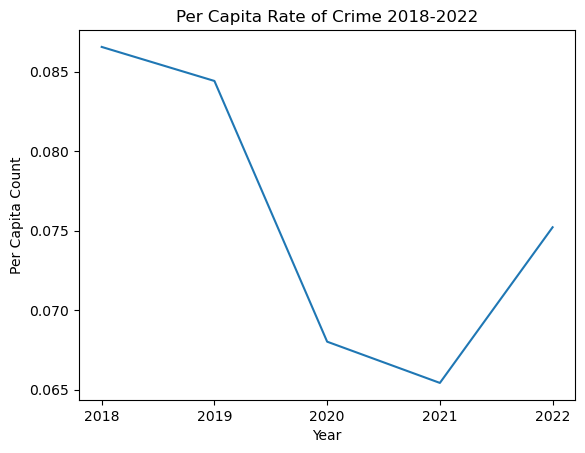

In [36]:
# Graph per capita crime rates over the 5 years
plt.plot(yearly_per_capita["Year"], yearly_per_capita["Per Capita Count"])

# Add labels
plt.xlabel("Year")
plt.ylabel("Per Capita Count")
plt.title("Per Capita Rate of Crime 2018-2022")

# Create new x-ticks
new_xticks = [2018, 2019, 2020, 2021, 2022]
plt.xticks(new_xticks)

plt.show()

In [37]:
# Look at per capita crime rate per district over the five year timespan
district_df = final_df[["Year", "District", "Primary Type", "Population", "Zipcode"]]
district_df

# Get the population per district by creating a new data frame and dropping any unique combinations of distict, zip code, and population
unique_pop = district_df[["District", "Zipcode", "Population"]].drop_duplicates()
pop_per_district = unique_pop.groupby("District")["Population"].sum()

# Get the per capita crime count
cnt_per_district = district_df.groupby("District")["Primary Type"].count()

# Get the per capita crime count
per_cap_crime_cnt = cnt_per_district/pop_per_district

# Put in a data frame
district_per_capita = pd.DataFrame({"District" : per_cap_crime_cnt.index, "Per Capita Crime Count" : per_cap_crime_cnt.values})
district_per_capita

,District,Per Capita Crime Count
0,1,0.097490
1,2,0.056675
2,3,0.055896
3,4,0.067163
4,5,0.036991
5,6,0.066932
6,7,0.079481
7,8,0.042925
8,9,0.024156
9,10,0.030581


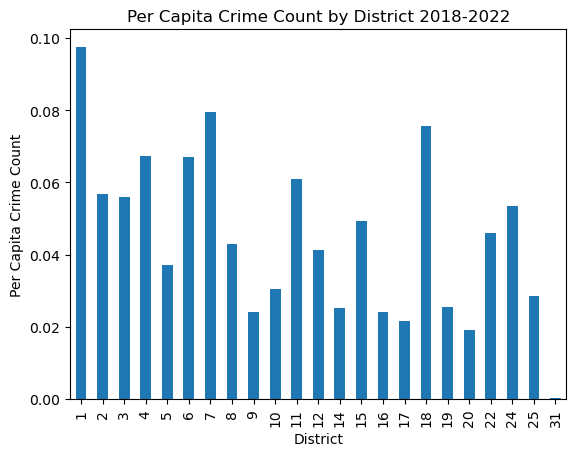

In [38]:
# Graph the results
district_per_capita.plot.bar(x='District', y='Per Capita Crime Count', legend=False)

# Set labels and title
plt.xlabel('District')
plt.ylabel('Per Capita Crime Count')
plt.title('Per Capita Crime Count by District 2018-2022')

# Display the plot
plt.show()

In [43]:
# Look at per capita crime rate per primary type over the five year timespan

# Get the population per primary type by removing duplicates
unique_type_pop = final_df[["Primary Type", "Zipcode", "Population"]].drop_duplicates()
pop_per_type = unique_type_pop.groupby("Primary Type")["Population"].sum()

# Get the crime count
cnt_per_type = district_df.groupby("Primary Type")["Primary Type"].count()

# Get the per capita crime count
per_cap_crime_type = cnt_per_type/pop_per_type

# Put in a data frame
type_per_capita = pd.DataFrame({"Primary Type" : per_cap_crime_type.index, "Per Capita Crime Count" : per_cap_crime_type.values})
type_per_capita.sort_values(by="Per Capita Crime Count", ascending=False, inplace=True)
type_per_capita

,Primary Type,Per Capita Crime Count
10,THEFT (ALL TYPES),0.043551
1,ASSAULT & BATTERY,0.029118
5,MINOR PROPERTY CRIME,0.014019
8,OTHER MINOR CRIMES,0.007854
2,DRUG RELATED,0.003952
11,WEAPONS RELATED CRIME,0.003509
9,SEXUAL RELATED CRIME,0.001138
7,OFFENSE INVOLVING CHILDREN,0.000908
3,HOMICIDE,0.000338
0,ARSON,0.000218


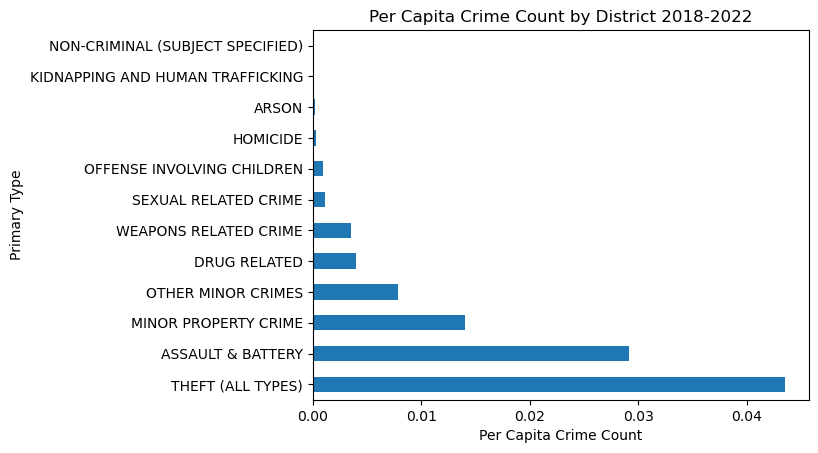

In [44]:
# Graph the results
type_per_capita.plot.barh(x='Primary Type', y='Per Capita Crime Count', legend=False)

# Set labels and title
plt.xlabel('Per Capita Crime Count')
plt.ylabel('Primary Type')
plt.title('Per Capita Crime Count by District 2018-2022')

# Display the plot
plt.show()